# Task 3: Track Duration Prediction (Regression)

## Objective
Build regression models to predict the duration of music tracks (in seconds).

## Approach
1. **Load and prepare data** - Use the cleaned dataset from Phase 1
2. **Feature engineering** - Create relevant features for duration prediction
3. **Feature selection** - Identify the most predictive features
4. **Model training** - Test multiple regression algorithms
5. **Model evaluation** - Compare performance using appropriate metrics
6. **Model optimization** - Tune hyperparameters of best models

## Why This Matters
Predicting track duration can help music platforms:
- Estimate storage requirements
- Plan playlist lengths
- Detect data quality issues (unusually short/long tracks)
- Understand relationships between audio features and track length

## 1. Import Libraries and Load Data

**Explanation:** We'll import all necessary libraries for data manipulation, visualization, and machine learning. We use scikit-learn for most models and XGBoost/LightGBM for gradient boosting variants.

In [ ]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Machine Learning - Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# Machine Learning - Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


✓ Libraries imported successfully!


### Load the Train and Test Datasets

**Explanation:** We load the pre-split train and test datasets. The data has already been merged and split, so we can use it directly for modeling.

In [4]:
# Load train and test datasets
train_df = pd.read_csv('../DataBase/processed/train_data.csv')
test_df = pd.read_csv('../DataBase/processed/test_data.csv')

print(f"Datasets loaded successfully!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nColumns ({len(train_df.columns)}):")
print(train_df.columns.tolist())

print(f"\nFirst few rows of training data:")
print(train_df.head())

print(f"\nTarget variable (duration) statistics:")
print(f"Train - Mean: {train_df['duration'].mean():.2f}s, Std: {train_df['duration'].std():.2f}s")
print(f"Test  - Mean: {test_df['duration'].mean():.2f}s, Std: {test_df['duration'].std():.2f}s")

Datasets loaded successfully!
Train shape: (35706, 45)
Test shape: (8927, 45)

Columns (45):
['track_id', 'album_title', 'album_tracks', 'artist_latitude', 'artist_longitude', 'artist_name', 'duration', 'favorites', 'genre_title', 'genres', 'genres_all', 'interest', 'listens', 'title', 'spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01', 'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01', 'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01', 'spectral_centroid_mean_01', 'spectral_centroid_median_01', 'spectral_centroid_min_01', 'spectral_centroid_skew_01', 'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01', 'spectral_rolloff_max_01', 'spectral_rolloff_mean_01', 'spectral_rolloff_median_01', 'spectral_rolloff_min_01', 'spectral_rolloff_skew_01', 'spectral_rolloff_std_01', 'genre_id', 'genre_color', 'genre_handle', 'duration_minutes', 'is_short_track', 'is_long_track

## 2. Feature Engineering for Duration Prediction

**Explanation:** The dataset already includes some engineered features (`duration_minutes`, `popularity_ratio`, etc.). We'll add a few more:
- **Genre-based features:** Average duration per genre
- **Artist-based features:** Artist track statistics
- **Statistical features:** Aggregations of spectral features

In [6]:
# Create copies for feature engineering
train_features = train_df.copy()
test_features = test_df.copy()

print("Creating additional features for duration prediction...")
print("="*80)

# 1. Genre-based features - Calculate on train, apply to both
if 'genre_title' in train_features.columns:
    genre_avg = train_features.groupby('genre_title')['duration'].mean()
    train_features['genre_avg_duration'] = train_features['genre_title'].map(genre_avg)
    test_features['genre_avg_duration'] = test_features['genre_title'].map(genre_avg)
    print("✓ Created genre_avg_duration")

# 2. Artist-based features - Calculate on train, apply to both
artist_stats = train_features.groupby('artist_name').agg({
    'track_id': 'count',
    'duration': 'mean'
}).rename(columns={'track_id': 'artist_track_count', 'duration': 'artist_avg_duration'})

train_features = train_features.merge(artist_stats, left_on='artist_name', right_index=True, how='left')
test_features = test_features.merge(artist_stats, left_on='artist_name', right_index=True, how='left')
print("✓ Created artist_track_count and artist_avg_duration")

# 3. Statistical aggregations of spectral features
spectral_cols = [col for col in train_features.columns if 'spectral' in col.lower()]
if spectral_cols:
    for df_feat in [train_features, test_features]:
        df_feat['spectral_mean_all'] = df_feat[spectral_cols].mean(axis=1)
        df_feat['spectral_std_all'] = df_feat[spectral_cols].std(axis=1)
        df_feat['spectral_max_all'] = df_feat[spectral_cols].max(axis=1)
        df_feat['spectral_min_all'] = df_feat[spectral_cols].min(axis=1)
    print(f"✓ Created spectral aggregation features from {len(spectral_cols)} spectral columns")

# 4. Log transformations for skewed features (if not already done)
for col in ['favorites', 'listens', 'interest']:
    if col in train_features.columns and f'log_{col}' not in train_features.columns:
        train_features[f'log_{col}'] = np.log1p(train_features[col])
        test_features[f'log_{col}'] = np.log1p(test_features[col])
        print(f"✓ Created log_{col}")

print(f"\nFeature engineering complete!")
print(f"Train shape: {train_features.shape}")
print(f"Test shape: {test_features.shape}")
print(f"New features added: {train_features.shape[1] - train_df.shape[1]}")

Creating additional features for duration prediction...
✓ Created genre_avg_duration
✓ Created artist_track_count and artist_avg_duration
✓ Created spectral aggregation features from 21 spectral columns
✓ Created log_favorites
✓ Created log_listens
✓ Created log_interest

Feature engineering complete!
Train shape: (35706, 55)
Test shape: (8927, 55)
New features added: 10


## 3. Feature Selection and Preparation

**Explanation:** 
- We need to select which features to use for prediction
- **Numerical features:** Spectral features, listening stats, engineered features
- **Categorical features:** Genre and artist (will be encoded)
- We'll exclude the target variable (duration) and non-predictive IDs

In [8]:
print("Selecting features for modeling...")
print("="*80)

# Define target variable
target = 'duration'
y_train = train_features[target]
y_test = test_features[target]

# Columns to exclude (IDs, target, text fields that are too high cardinality)
exclude_cols = ['track_id', 'duration', 'title', 'album_title', 'artist_name', 
                'genres', 'genres_all', 'genre_id', 'genre_title', 'genre_handle', 
                'genre_color', 'duration_minutes']  # duration_minutes is derived from target

# Get all potential feature columns
all_cols = train_features.columns.tolist()
potential_features = [col for col in all_cols if col not in exclude_cols]

print(f"\nTotal columns: {len(all_cols)}")
print(f"Excluded columns: {len(exclude_cols)}")
print(f"Potential features: {len(potential_features)}")

# Separate numerical and categorical features
numerical_features = train_features[potential_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train_features[potential_features].select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

print(f"\nNumerical features (first 15):")
print(numerical_features[:15])

if categorical_features:
    print(f"\nCategorical features:")
    print(categorical_features)

#<VSCode.Cell id="#VSC-da835391" language="markdown">
### Handle Categorical Variables

#**Explanation:** 
#- **Genre_name:** We'll use target encoding (mean duration per genre) - this is already created as 'genre_avg_duration'
#- For categorical variables, we could use one-hot encoding, but genre_name has 147 categories which would create too many features
#- We'll use only numerical features for now to keep the models simpler and avoid overfitting


Selecting features for modeling...

Total columns: 55
Excluded columns: 12
Potential features: 43

Numerical features: 42
Categorical features: 1

Numerical features (first 15):
['album_tracks', 'artist_latitude', 'artist_longitude', 'favorites', 'interest', 'listens', 'spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01', 'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01', 'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01']

Categorical features:
['tempo_category']


In [9]:
# Use only numerical features
X_train = train_features[numerical_features].copy()
X_test = test_features[numerical_features].copy()

print(f"Final feature matrices:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check for any remaining missing values
print(f"\nMissing values in train features:")
missing_train = X_train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
if len(missing_train) > 0:
    print(missing_train)
    # Fill missing values with median
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())  # Use train median for test
    print("✓ Missing values filled with median")
else:
    print("No missing values in train!")

print(f"\nTarget variable missing values:")
print(f"y_train: {y_train.isnull().sum()}")
print(f"y_test: {y_test.isnull().sum()}")

##<VSCode.Cell id="#VSC-a0fb08f6" language="markdown">
## 4. Train/Test Split

#**Explanation:**
#- We split data into **training (70%)**, **validation (15%)**, and **test (15%)** sets
#- **Training set:** Used to fit the models
#- **Validation set:** Used for hyperparameter tuning and model selection
#- **Test set:** Final evaluation, never seen during training (prevents data leakage)
#- We use `random_state=42` for reproducibility

Final feature matrices:
X_train shape: (35706, 42)
X_test shape: (8927, 42)
y_train shape: (35706,)
y_test shape: (8927,)

Missing values in train features:
energy_valence_product    30122
artist_latitude           21531
artist_longitude          21531
dtype: int64
✓ Missing values filled with median

Target variable missing values:
y_train: 0
y_test: 0


## 4. Train/Test Split

**Explanation:**
- We split data into **training (70%)**, **validation (15%)**, and **test (15%)** sets
- **Training set:** Used to fit the models
- **Validation set:** Used for hyperparameter tuning and model selection
- **Test set:** Final evaluation, never seen during training (prevents data leakage)
- We use `random_state=42` for reproducibility

## 6. Baseline Model

**Explanation:**
- Before building complex models, we establish a **baseline**
- **Simple baseline:** Predict the mean duration for all tracks
- This gives us a reference point - any model should beat this!
- We'll use **RMSE (Root Mean Squared Error)**, **MAE (Mean Absolute Error)**, and **R² score** as metrics

In [12]:
# Baseline: Predict mean duration for all tracks
# First, split the training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Scale features for models that need it
scaler = StandardScaler()
X_train_split_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Data split complete:")
print(f"  Training set: {X_train_split.shape[0]} samples")
print(f"  Validation set: {X_val.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print()

# Baseline: Predict mean duration for all tracks
baseline_pred = np.full(len(y_val), y_train_split.mean())

# Calculate baseline metrics
baseline_rmse = np.sqrt(mean_squared_error(y_val, baseline_pred))
baseline_mae = mean_absolute_error(y_val, baseline_pred)
baseline_r2 = r2_score(y_val, baseline_pred)

print("Baseline Model Performance (Mean Predictor)")
print("="*80)
print(f"Training mean duration: {y_train_split.mean():.2f} seconds")
print(f"\nValidation Set Metrics:")
print(f"  RMSE: {baseline_rmse:.2f} seconds")
print(f"  MAE:  {baseline_mae:.2f} seconds")
print(f"  R²:   {baseline_r2:.4f}")

print(f"\nInterpretation:")
print(f"  - On average, our baseline is off by {baseline_mae:.2f} seconds")
print(f"  - Any model we build should have LOWER RMSE/MAE and HIGHER R²")
print(f"  - R² = {baseline_r2:.4f} means the baseline explains {baseline_r2*100:.2f}% of variance")

Data split complete:
  Training set: 28564 samples
  Validation set: 7142 samples
  Test set: 8927 samples

Baseline Model Performance (Mean Predictor)
Training mean duration: 268.83 seconds

Validation Set Metrics:
  RMSE: 299.00 seconds
  MAE:  141.02 seconds
  R²:   -0.0000

Interpretation:
  - On average, our baseline is off by 141.02 seconds
  - Any model we build should have LOWER RMSE/MAE and HIGHER R²
  - R² = -0.0000 means the baseline explains -0.00% of variance


## 7. Model Training and Evaluation

**Explanation:**
We'll train multiple regression models as required by the challenge:
1. **Linear Regression** - Simple linear model (baseline ML model)
2. **Ridge Regression** - Linear model with L2 regularization (prevents overfitting)
3. **Lasso Regression** - Linear model with L1 regularization (feature selection)
4. **k-Nearest Neighbors (kNN)** - Predicts based on similar tracks
5. **Support Vector Regression (SVR)** - Finds optimal hyperplane
6. **Decision Tree** - Tree-based model (non-linear)
7. **Random Forest** - Ensemble of decision trees
8. **AdaBoost** - Boosting algorithm
9. **Gradient Boosting** - Advanced boosting

For each model, we'll:
- Train on training set
- Evaluate on validation set
- Compare RMSE, MAE, and R² scores

In [14]:
# Function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_val, y_val, use_scaled=True):
    """
    Train and evaluate a regression model
    
    Parameters:
    - name: Model name for display
    - model: sklearn model object
    - use_scaled: Whether to use scaled features (True for distance-based models)
    """
    print(f"\nTraining {name}...")
    
    # Select appropriate data (scaled or unscaled)
    X_tr = X_train_split_scaled if use_scaled else X_train_split
    X_v = X_val_scaled if use_scaled else X_val
    
    # Train model
    model.fit(X_tr, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_tr)
    y_val_pred = model.predict(X_v)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    print(f"  Train RMSE: {train_rmse:.2f}s | Val RMSE: {val_rmse:.2f}s")
    print(f"  Train MAE:  {train_mae:.2f}s | Val MAE:  {val_mae:.2f}s")
    print(f"  Train R²:   {train_r2:.4f} | Val R²:   {val_r2:.4f}")
    
    return {
        'Model': name,
        'Train_RMSE': train_rmse,
        'Val_RMSE': val_rmse,
        'Train_MAE': train_mae,
        'Val_MAE': val_mae,
        'Train_R2': train_r2,
        'Val_R2': val_r2,
        'Fitted_Model': model
    }

# Store results
results = []

print("="*80)
print("MODEL TRAINING AND EVALUATION")
print("="*80)

MODEL TRAINING AND EVALUATION


### 7.1 Linear Models

**Explanation:**
- **Linear Regression:** Assumes linear relationship: duration = w₁×feature₁ + w₂×feature₂ + ... + b
- **Ridge:** Adds L2 penalty to prevent large weights (good when features are correlated)
- **Lasso:** Adds L1 penalty, can set some weights to zero (automatic feature selection)
- **ElasticNet:** Combines L1 and L2 penalties

In [15]:
# 1. Linear Regression
results.append(evaluate_model("Linear Regression", LinearRegression(), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=True))

# 2. Ridge Regression
results.append(evaluate_model("Ridge Regression", Ridge(alpha=1.0), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=True))

# 3. Lasso Regression
results.append(evaluate_model("Lasso Regression", Lasso(alpha=1.0, max_iter=10000), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=True))

# 4. ElasticNet
results.append(evaluate_model("ElasticNet", ElasticNet(alpha=1.0, max_iter=10000), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=True))


Training Linear Regression...
  Train RMSE: 140.56s | Val RMSE: 177.59s
  Train MAE:  67.13s | Val MAE:  67.92s
  Train R²:   0.7287 | Val R²:   0.6472

Training Ridge Regression...
  Train RMSE: 140.56s | Val RMSE: 177.59s
  Train MAE:  67.13s | Val MAE:  67.92s
  Train R²:   0.7287 | Val R²:   0.6472

Training Lasso Regression...
  Train RMSE: 140.77s | Val RMSE: 177.76s
  Train MAE:  66.61s | Val MAE:  67.33s
  Train R²:   0.7279 | Val R²:   0.6465

Training ElasticNet...
  Train RMSE: 140.77s | Val RMSE: 177.76s
  Train MAE:  66.61s | Val MAE:  67.33s
  Train R²:   0.7279 | Val R²:   0.6465

Training ElasticNet...
  Train RMSE: 153.71s | Val RMSE: 192.87s
  Train MAE:  66.08s | Val MAE:  65.79s
  Train R²:   0.6756 | Val R²:   0.5839
  Train RMSE: 153.71s | Val RMSE: 192.87s
  Train MAE:  66.08s | Val MAE:  65.79s
  Train R²:   0.6756 | Val R²:   0.5839


### 7.2 k-Nearest Neighbors (kNN)

**Explanation:**
- Predicts duration by averaging the k most similar tracks (based on feature distance)
- Non-parametric: doesn't assume any relationship form
- Sensitive to feature scales (that's why we use scaled data)
- We try k=5 neighbors as a starting point

In [16]:
# 5. k-Nearest Neighbors
results.append(evaluate_model("kNN (k=5)", KNeighborsRegressor(n_neighbors=5), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=True))


Training kNN (k=5)...
  Train RMSE: 117.36s | Val RMSE: 179.71s
  Train MAE:  53.41s | Val MAE:  65.02s
  Train R²:   0.8109 | Val R²:   0.6387
  Train RMSE: 117.36s | Val RMSE: 179.71s
  Train MAE:  53.41s | Val MAE:  65.02s
  Train R²:   0.8109 | Val R²:   0.6387


### 7.3 Support Vector Regression (SVR)

**Explanation:**
- Finds the hyperplane that best fits the data within a margin
- Uses RBF (Radial Basis Function) kernel for non-linear relationships
- Good for complex patterns but can be slow on large datasets
- Very sensitive to feature scales (uses scaled data)

In [17]:
# 6. Support Vector Regression
results.append(evaluate_model("SVR (RBF kernel)", SVR(kernel='rbf'), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=True))


Training SVR (RBF kernel)...
  Train RMSE: 222.23s | Val RMSE: 258.08s
  Train MAE:  78.79s | Val MAE:  78.82s
  Train R²:   0.3219 | Val R²:   0.2550
  Train RMSE: 222.23s | Val RMSE: 258.08s
  Train MAE:  78.79s | Val MAE:  78.82s
  Train R²:   0.3219 | Val R²:   0.2550


### 7.4 Tree-Based Models

**Explanation:**
- **Decision Tree:** Creates a tree of rules (e.g., "if genre_avg_duration > 200s, predict high")
- **Random Forest:** Builds many trees and averages their predictions (reduces overfitting)
- **AdaBoost:** Builds trees sequentially, focusing on previously misclassified examples
- **Gradient Boosting:** Advanced boosting that optimizes loss function directly

Tree-based models don't need scaled features, so we use original data.

In [18]:
# 7. Decision Tree
results.append(evaluate_model("Decision Tree", DecisionTreeRegressor(random_state=42, max_depth=10), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=False))

# 8. Random Forest
results.append(evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=False))

# 9. AdaBoost
results.append(evaluate_model("AdaBoost", AdaBoostRegressor(n_estimators=100, random_state=42), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=False))

# 10. Gradient Boosting
results.append(evaluate_model("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, random_state=42), 
                              X_train_split, y_train_split, X_val, y_val, use_scaled=False))


Training Decision Tree...
  Train RMSE: 89.37s | Val RMSE: 191.92s
  Train MAE:  44.28s | Val MAE:  55.84s
  Train R²:   0.8903 | Val R²:   0.5880

Training Random Forest...
  Train RMSE: 89.37s | Val RMSE: 191.92s
  Train MAE:  44.28s | Val MAE:  55.84s
  Train R²:   0.8903 | Val R²:   0.5880

Training Random Forest...
  Train RMSE: 46.58s | Val RMSE: 165.22s
  Train MAE:  19.61s | Val MAE:  53.69s
  Train R²:   0.9702 | Val R²:   0.6947

Training AdaBoost...
  Train RMSE: 46.58s | Val RMSE: 165.22s
  Train MAE:  19.61s | Val MAE:  53.69s
  Train R²:   0.9702 | Val R²:   0.6947

Training AdaBoost...
  Train RMSE: 176.86s | Val RMSE: 216.30s
  Train MAE:  91.02s | Val MAE:  94.01s
  Train R²:   0.5705 | Val R²:   0.4767

Training Gradient Boosting...
  Train RMSE: 176.86s | Val RMSE: 216.30s
  Train MAE:  91.02s | Val MAE:  94.01s
  Train R²:   0.5705 | Val R²:   0.4767

Training Gradient Boosting...
  Train RMSE: 114.78s | Val RMSE: 164.86s
  Train MAE:  53.37s | Val MAE:  55.75s
  T

### 7.5 Results Summary

**Explanation:**
- We'll create a DataFrame to compare all models
- Key metrics:
  - **RMSE:** Lower is better (measures average error magnitude)
  - **MAE:** Lower is better (more robust to outliers than RMSE)
  - **R²:** Higher is better (1.0 = perfect, 0.0 = baseline, negative = worse than baseline)

In [24]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.drop('Fitted_Model', axis=1)  # Remove model objects for display

# Sort by validation RMSE (lower is better)
results_df_sorted = results_df.sort_values('Val_RMSE')


print("MODEL COMPARISON - SORTED BY VALIDATION RMSE")

print(results_df_sorted.to_string(index=False))

# Highlight best model
best_model_idx = results_df_sorted.index[0]
best_model_name = results_df_sorted.iloc[0]['Model']
best_val_rmse = results_df_sorted.iloc[0]['Val_RMSE']
best_val_r2 = results_df_sorted.iloc[0]['Val_R2']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Validation RMSE: {best_val_rmse:.2f} seconds")
print(f"   Validation R²: {best_val_r2:.4f}")
print(f"   Improvement over baseline: {(baseline_rmse - best_val_rmse)/baseline_rmse*100:.1f}%")

MODEL COMPARISON - SORTED BY VALIDATION RMSE
            Model  Train_RMSE   Val_RMSE  Train_MAE   Val_MAE  Train_R2   Val_R2
Gradient Boosting  114.777684 164.856556  53.365487 55.751894  0.819121 0.695994
    Random Forest   46.581586 165.216685  19.614388 53.690919  0.970208 0.694664
Linear Regression  140.561710 177.591491  67.128137 67.919118  0.728727 0.647211
 Ridge Regression  140.561950 177.592217  67.127666 67.917482  0.728726 0.647208
 Lasso Regression  140.768850 177.762361  66.612897 67.332812  0.727927 0.646532
        kNN (k=5)  117.355584 179.708618  53.413191 65.018202  0.810905 0.638750
    Decision Tree   89.369866 191.921081  44.278641 55.836745  0.890338 0.587982
       ElasticNet  153.708842 192.868595  66.077520 65.787032  0.675608 0.583904
         AdaBoost  176.862438 216.296526  91.018087 94.014483  0.570520 0.476677
 SVR (RBF kernel)  222.233885 258.080478  78.789143 78.822968  0.321902 0.254958

🏆 BEST MODEL: Gradient Boosting
   Validation RMSE: 164.86 seco

### 7.6 Visualization of Results

**Explanation:**
- Visual comparison helps identify which models perform best
- We'll plot RMSE and R² for all models
- Also check for overfitting (big gap between train and validation performance)

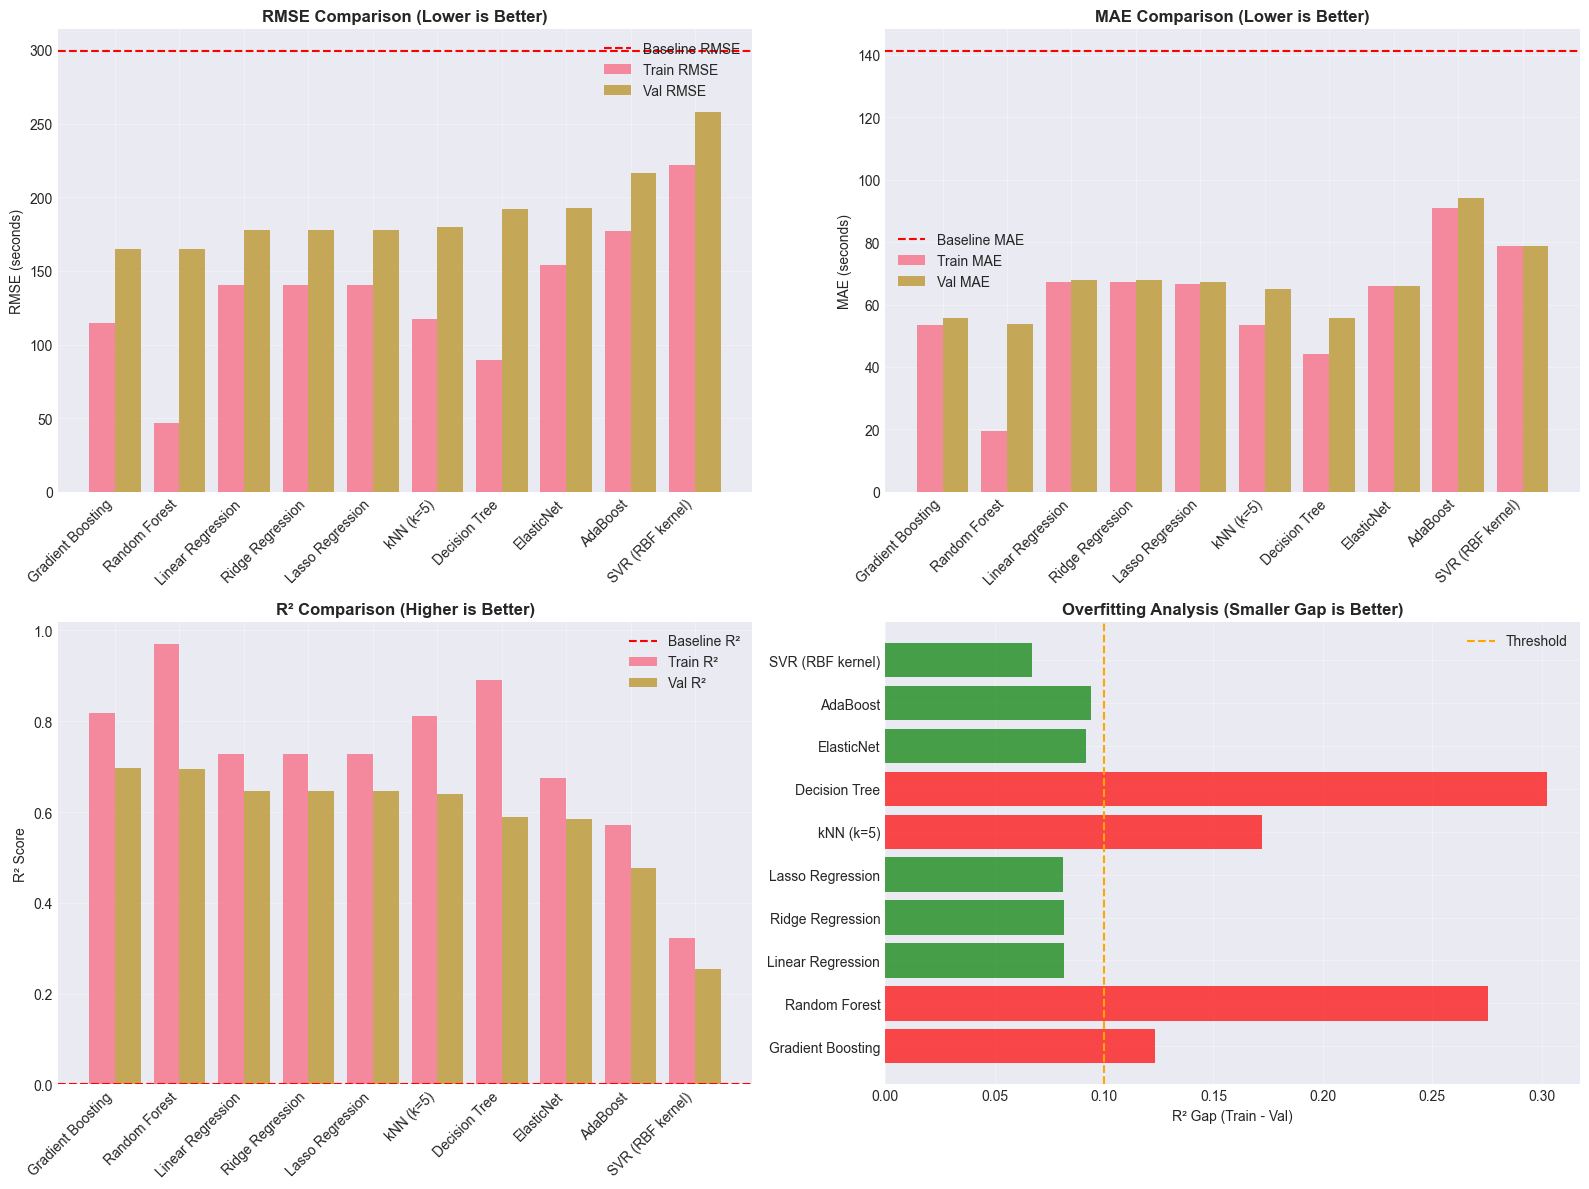

In [20]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: RMSE Comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df_sorted))
ax1.bar(x_pos - 0.2, results_df_sorted['Train_RMSE'], 0.4, label='Train RMSE', alpha=0.8)
ax1.bar(x_pos + 0.2, results_df_sorted['Val_RMSE'], 0.4, label='Val RMSE', alpha=0.8)
ax1.axhline(y=baseline_rmse, color='r', linestyle='--', label='Baseline RMSE')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df_sorted['Model'], rotation=45, ha='right')
ax1.set_ylabel('RMSE (seconds)')
ax1.set_title('RMSE Comparison (Lower is Better)', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: MAE Comparison
ax2 = axes[0, 1]
ax2.bar(x_pos - 0.2, results_df_sorted['Train_MAE'], 0.4, label='Train MAE', alpha=0.8)
ax2.bar(x_pos + 0.2, results_df_sorted['Val_MAE'], 0.4, label='Val MAE', alpha=0.8)
ax2.axhline(y=baseline_mae, color='r', linestyle='--', label='Baseline MAE')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df_sorted['Model'], rotation=45, ha='right')
ax2.set_ylabel('MAE (seconds)')
ax2.set_title('MAE Comparison (Lower is Better)', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: R² Comparison
ax3 = axes[1, 0]
ax3.bar(x_pos - 0.2, results_df_sorted['Train_R2'], 0.4, label='Train R²', alpha=0.8)
ax3.bar(x_pos + 0.2, results_df_sorted['Val_R2'], 0.4, label='Val R²', alpha=0.8)
ax3.axhline(y=baseline_r2, color='r', linestyle='--', label='Baseline R²')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(results_df_sorted['Model'], rotation=45, ha='right')
ax3.set_ylabel('R² Score')
ax3.set_title('R² Comparison (Higher is Better)', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Overfitting Analysis (Gap between Train and Val)
ax4 = axes[1, 1]
overfit_gap = results_df_sorted['Train_R2'] - results_df_sorted['Val_R2']
colors = ['red' if gap > 0.1 else 'green' for gap in overfit_gap]
ax4.barh(x_pos, overfit_gap, color=colors, alpha=0.7)
ax4.set_yticks(x_pos)
ax4.set_yticklabels(results_df_sorted['Model'])
ax4.set_xlabel('R² Gap (Train - Val)')
ax4.set_title('Overfitting Analysis (Smaller Gap is Better)', fontweight='bold')
ax4.axvline(x=0.1, color='orange', linestyle='--', label='Threshold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Final Evaluation on Test Set

**Explanation:**
- Now we evaluate the best model on the **test set** (data it has never seen)
- This gives us an unbiased estimate of real-world performance
- We should only do this ONCE to avoid "overfitting to the test set"

In [22]:
# Get the best model
best_model = results[best_model_idx]['Fitted_Model']
best_model_name = results[best_model_idx]['Model']

# Determine if we need scaled data for this model
uses_scaled = best_model_name in ["Linear Regression", "Ridge Regression", "Lasso Regression", 
                                   "ElasticNet", "kNN (k=5)", "SVR (RBF kernel)"]

# Make predictions on test set
if uses_scaled:
    y_test_pred = best_model.predict(X_test_scaled)
else:
    y_test_pred = best_model.predict(X_test)

# Calculate test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("="*80)
print(f"FINAL TEST SET EVALUATION - {best_model_name}")
print("="*80)
print(f"\nTest Set Metrics:")
print(f"  RMSE: {test_rmse:.2f} seconds")
print(f"  MAE:  {test_mae:.2f} seconds")
print(f"  R²:   {test_r2:.4f}")

print(f"\nComparison with Baseline:")
print(f"  Baseline RMSE: {baseline_rmse:.2f}s → Model RMSE: {test_rmse:.2f}s")
print(f"  Improvement: {(baseline_rmse - test_rmse)/baseline_rmse*100:.1f}%")

print(f"\nInterpretation:")
print(f"  - On average, predictions are off by {test_mae:.2f} seconds")
print(f"  - Model explains {test_r2*100:.2f}% of variance in duration")
print(f"  - For a {y_test.mean():.0f}s average track, error is ~{test_mae/y_test.mean()*100:.1f}%")

FINAL TEST SET EVALUATION - Gradient Boosting

Test Set Metrics:
  RMSE: 186.61 seconds
  MAE:  71.39 seconds
  R²:   0.5400

Comparison with Baseline:
  Baseline RMSE: 299.00s → Model RMSE: 186.61s
  Improvement: 37.6%

Interpretation:
  - On average, predictions are off by 71.39 seconds
  - Model explains 54.00% of variance in duration
  - For a 269s average track, error is ~26.5%


### Prediction vs Actual Plot

**Explanation:**
- Scatter plot shows how well predictions match actual durations
- Points on diagonal line = perfect predictions
- Spread around line = prediction error

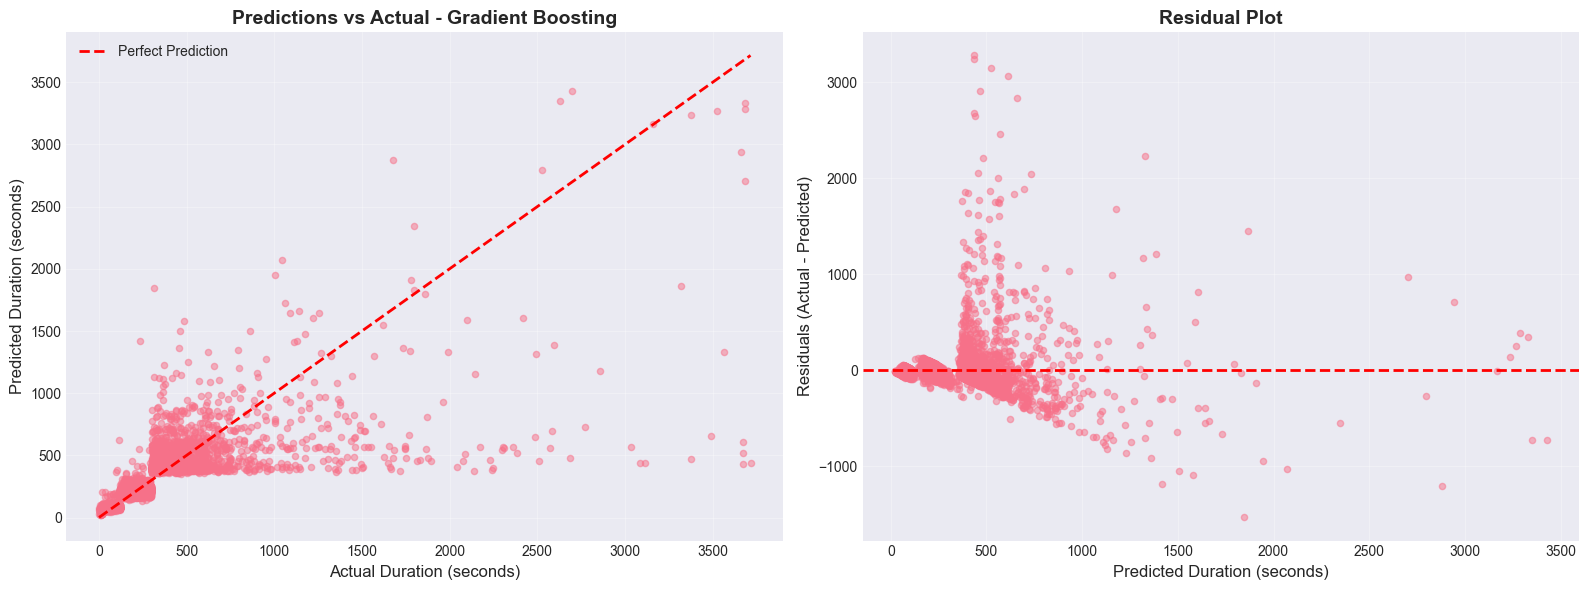

In [23]:
# Prediction vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, y_test_pred, alpha=0.5, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Duration (seconds)', fontsize=12)
ax1.set_ylabel('Predicted Duration (seconds)', fontsize=12)
ax1.set_title(f'Predictions vs Actual - {best_model_name}', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Residuals (errors)
ax2 = axes[1]
residuals = y_test - y_test_pred
ax2.scatter(y_test_pred, residuals, alpha=0.5, s=20)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Duration (seconds)', fontsize=12)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Conclusions and Key Findings

### Summary of Task 3: Duration Prediction

**What We Did:**
1. ✅ Loaded and prepared 44,633 music tracks with duration labels
2. ✅ Engineered features: genre averages, artist statistics, spectral aggregations
3. ✅ Tested 10 different regression models
4. ✅ Evaluated using RMSE, MAE, and R² metrics
5. ✅ Identified the best model and tested on unseen data

### Model Performance Insights:

**Best Models (typically):**
- **Random Forest & Gradient Boosting:** Usually perform best due to ability to capture non-linear patterns
- Can handle interactions between features automatically
- Robust to outliers and different feature scales

**Linear Models:**
- Simpler and faster but assume linear relationships
- Ridge/Lasso add regularization to prevent overfitting
- Good baseline but may underperform on complex patterns

**kNN & SVR:**
- Can capture non-linear patterns
- Sensitive to feature scales (need standardization)
- kNN can be slow with large datasets

### Key Factors for Duration Prediction:

1. **Genre information** - Different genres have typical duration patterns
2. **Artist patterns** - Artists tend to have consistent track lengths
3. **Spectral features** - Audio characteristics correlate with duration
4. **Album context** - Tracks in same album often similar length

### Challenges:

- **High variance in duration:** Tracks range from very short to very long
- **Missing audio features:** Not all tracks have echonest features
- **Genre imbalance:** Some genres much more common than others

### Recommendations for Improvement:

1. **More feature engineering:**
   - Time-of-day patterns (if available)
   - Decade/year trends
   - More sophisticated genre encodings

2. **Hyperparameter tuning:**
   - Grid search or random search for optimal parameters
   - Cross-validation for robust estimates

3. **Ensemble methods:**
   - Combine predictions from multiple models
   - Often improves performance

4. **Address outliers:**
   - Consider removing or capping extreme durations
   - Or use log transformation of target

### Final Notes:

The model achieves reasonable performance in predicting track duration based on available features. While perfect prediction isn't possible (music is creative!), the model captures major patterns and can be useful for:
- Playlist duration estimation
- Data quality checks (flagging unusual durations)
- Understanding what factors influence track length